In [4]:
from helpers import *

k = 5
p = 50
n = 100
Z, M, B = create_factors(n, k, p+1, sig=1)

# Let rets be the last column of Z 
rets = Z[:, -1]
# redefine Z to be all the other columns except the last one
Z = Z[:, :-1]
Z = normalize_columns(Z)
X = Z[:, :k]
# Y = Z[:, k:]

knum = k
Zk, Theta_tru, svd_C = compute_k_truncated_svd(Z, k)

tsms_idx = tsms(Z, Zk, knum)
tsms_smin = smallest_singular_value(Z[:, tsms_idx])

_, Theta_hat = svd_convex_optimization(Z, .5*svd_C, knum)
sgl_idx = top_k_rows_indices(Theta_hat, knum)
sgl_smin = smallest_singular_value(Z[:, sgl_idx])

p1 = PRESS_statistic(rets, X)
p2 = PRESS_statistic(rets, Z)
p3 = PRESS_statistic(rets, Z[:, tsms_idx])
p4 = PRESS_statistic(rets, Z[:, sgl_idx])
print(p1, p2, p3, p4)

1.0177226466951792 1.9503697518321552 1.0177226466951792 1.0177226466951792


In [5]:
sgl_idx

array([2, 4, 3, 1, 0])

In [6]:
tsms_idx

array([0, 4, 1, 3, 2])

In [7]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import LeaveOneOut

def lasso_press(responses, predictors):
    # Create Lasso model with LOOCV
    model = LassoCV(cv=LeaveOneOut(), max_iter=10000)
    # Fit the model
    model.fit(predictors, responses)
    # Get the predicted responses using LOOCV
    loo_preds = model.predict(predictors)
    # Calculate the residuals
    residuals = responses - loo_preds
    # Calculate the PRESS statistic
    press_stat = np.sum(residuals**2)
    return press_stat


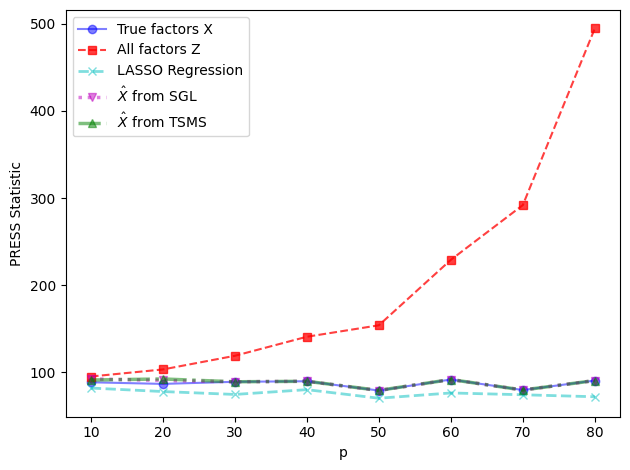

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpers import *

k = 5
n = 100

results = []
p_values = range(10, 81, 10)  # Values: 10, 20, ..., 100
nreps = 5  # Number of repetitions for each p

for p in p_values:
    for rep in range(nreps):
        Z, M, B = create_factors(n, k, p+1, sig=.9)

        rets = Z[:, -1]
        Z = Z[:, :-1]

        Z = normalize_columns(Z)
        X = Z[:, :k]

        knum = k
        Zk, Theta_tru, svd_C = compute_k_truncated_svd(Z, k)

        tsms_idx = tsms(Z, Zk, knum)
        _, Theta_hat = svd_convex_optimization(Z, .5*svd_C, knum)
        sgl_idx = top_k_rows_indices(Theta_hat, knum)

        methods = {
            'X': X,
            'Z': Z,
            'tsms': Z[:, tsms_idx],
            'sgl': Z[:, sgl_idx]
        }

        for method, data in methods.items():
            press_val = PRESS_statistic(rets, data)
            results.append({'p': p, 'method': method, 'PRESS': press_val, 'rep': rep})

         # Add LASSO
        press_val_lasso = lasso_press(rets, Z)
        results.append({'p': p, 'method': 'lasso', 'PRESS': press_val_lasso, 'rep': rep})

df = pd.DataFrame(results)

# Calculate average PRESS across repetitions
averages = df.groupby(['method', 'p']).PRESS.mean().reset_index()

# Define custom labels
labels = {
    'X': 'True factors X',
    'Z': 'All factors Z',
    'tsms': r'$\hat{X}$ from TSMS',
    'sgl': r'$\hat{X}$ from SGL',
    'lasso': 'LASSO Regression'
}

# Visualization
styles = {
    'X': {'color': 'b', 'linestyle': '-', 'marker': 'o', 'linewidth': 1.5, 'alpha': .5},
    'Z': {'color': 'r', 'linestyle': '--', 'marker': 's', 'linewidth': 1.5, 'alpha': 0.75},
    'tsms': {'color': 'g', 'linestyle': '-.', 'marker': '^', 'linewidth': 2.5, 'alpha': 0.5},
    'sgl': {'color': 'm', 'linestyle': ':', 'marker': 'v', 'linewidth': 2.5, 'alpha': 0.5},
    'lasso': {'color': 'c', 'linestyle': '--', 'marker': 'x', 'linewidth': 2.0, 'alpha': 0.5}
}

for method in averages['method'].unique():
    subset = averages[averages['method'] == method]
    plt.plot(subset['p'], subset['PRESS'], label=labels[method], **styles[method])

plt.xlabel('p')
plt.ylabel('PRESS Statistic')
plt.legend()
plt.tight_layout()
plt.savefig("PRESS_vs_p_avg_2.png", dpi=300)
plt.show()



